In [17]:
import numpy as np
from numpy import log10
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift
from scipy.integrate import odeint
from scipy import signal
from scipy.signal import firwin, remez,kaiser_atten, kaiser_beta
from scipy.signal import butter, lfilter
%matplotlib inline

# %% Константы и массивы
sampling_rate=5*10**11
sampling_time = 1/sampling_rate
N = 2048
time = np.arange (0, 3*10**(-9), sampling_time)
freq=np.linspace(0, sampling_rate/2, 2048)
lowcut = 2*10**9
highcut = 8*10**9
SNR = 10 #Отношение сигнал шум

In [18]:
# Задание гауссовского импульса
Gaussian_pulse = np.e ** (-5 * 10 ** (19) * (time - 1.5 * 10 ** (-9)) ** 2)

# Построение спектра гауссовского импульса
GaussFFT = fft(Gaussian_pulse, N)
spectr_Gauss = 20 * log10(np.abs(GaussFFT) / max(GaussFFT))


C:\Users\Elf\AppData\Local\Temp\ipykernel_15860\1752929134.py:6: RuntimeWarning: divide by zero encountered in log10
  spectr_Gauss = 20 * log10(np.abs(GaussFFT) / max(GaussFFT))
C:\Users\Elf\AppData\Local\Temp\ipykernel_15860\1752929134.py:6: RuntimeWarning: invalid value encountered in multiply
  spectr_Gauss = 20 * log10(np.abs(GaussFFT) / max(GaussFFT))


c:\Users\Elf\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


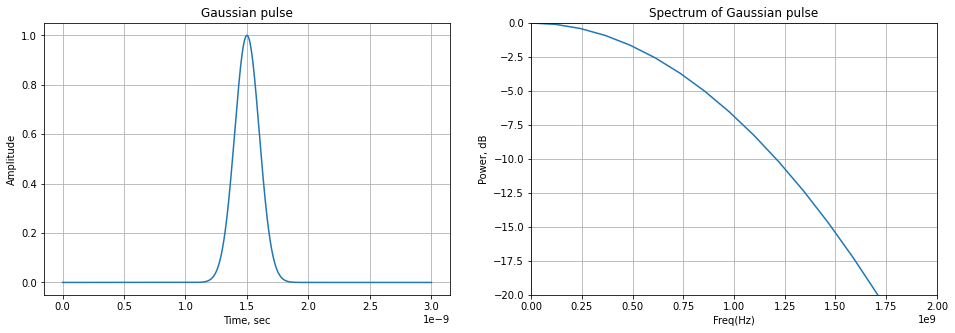

In [19]:
# СКИ во временной и в частотной областях
fig0 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, Gaussian_pulse)
plt.grid(True)
plt.xlabel("Time, sec")
plt.ylabel("Amplitude")
plt.title("Gaussian pulse")
plt.subplot(1, 2, 2)
plt.plot(freq, spectr_Gauss)
plt.xlabel("Freq(Hz)")
plt.ylabel("Power, dB")
plt.subplots_adjust(hspace=0.4)
plt.xlim(0, 2 * 10**9)
plt.ylim(-20, 0)
plt.title("Spectrum of Gaussian pulse")
plt.grid(True)

(0.0, 20000000000.0)

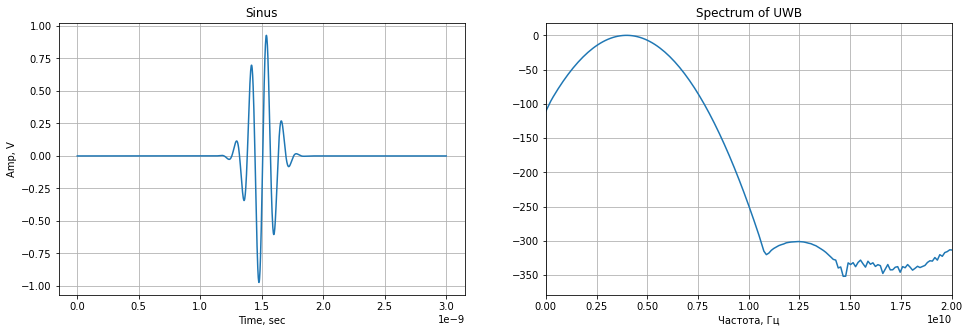

In [20]:
# Периодический сигнал, модулированный СКИ
sin = np.sin(5 * 10**10 * time)
UWB_tip = sin * Gaussian_pulse

# Построение спектра UWB-сигнала
FFT_UWB = fft(UWB_tip, N)
spectr_UWB = 20 * log10(abs(FFT_UWB) / max(abs((FFT_UWB))))

# Построение графиков для UWB сигнала во временной и частотной областях
fig1 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, sin * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Time, sec")
plt.ylabel("Amp, V")
plt.title("Sinus")
plt.subplot(1, 2, 2)
plt.plot(freq, spectr_UWB)
plt.grid(True)
plt.xlabel("Частота, Гц")
plt.title("Spectrum of UWB")
plt.xlim(0, 2 * 10**10)

In [21]:
# Работа генератора хаоса
x0, y0, z0 = 1, 1, 1  # Начальные условия
g, m = 0.17, 1.567  # Параметры системы

# ДУ системы
t = np.linspace(0, 200, 1501)

def Anishenko_Astahov(xyz, t):
    (
        x,
        y,
        z,
    ) = xyz
    dx_dt = m * x + y - x * z
    dy_dt = -x
    dz_dt = -g * z + g * np.heaviside(x, 0) * x**2
    return dx_dt, dy_dt, dz_dt

# Решение ДУ
h = odeint(Anishenko_Astahov, (x0, y0, z0), t)
# Транспонируем матрицу
x, y, z = h.T
t = time

def rect_wave(x, c, c0):  # Прямоугольная волна с начальной точкой c0 и шириной c
    if x >= (c + c0):
        r = 0.0
    elif x < c0:
        r = 0.0
    else:
        r = 1
    return r

straight = np.array([rect_wave(t, 1.2 * 10 ** (-9), 1.3 * 10 ** (-9)) for t in time])

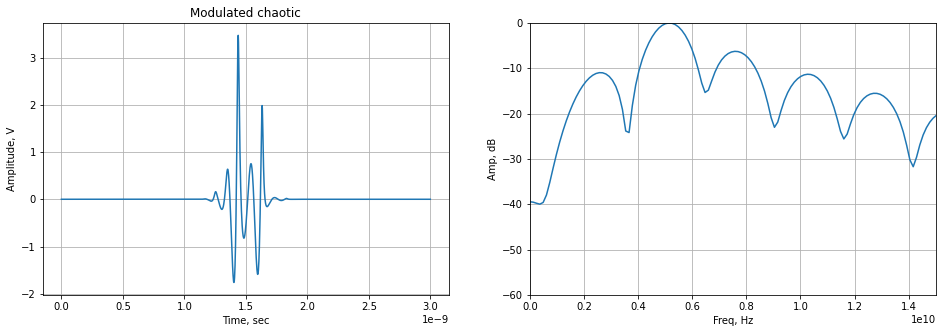

In [22]:
# Построение спектров
spectr_Chaos = abs((fft(x * Gaussian_pulse, N)))
spectr_Chaos_clean = abs((fft(x, N)))
spectr_Chaos_straight = abs((fft(x * straight, N)))

# Хаос во временной и частотной областях
fig2 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, x * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Time, sec")
plt.ylabel("Amplitude, V")
plt.title("Modulated chaotic")
plt.subplot(1, 2, 2)
plt.plot(freq, 20 * np.log10(spectr_Chaos / max(spectr_Chaos)))
plt.xlim(0, 1.5 * 10 ** (10))
plt.ylim(-60, 0)
plt.xlabel("Freq, Hz")
plt.ylabel("Amp, dB")
plt.grid(True)

Text(0, 0.5, 'Amp, dB')

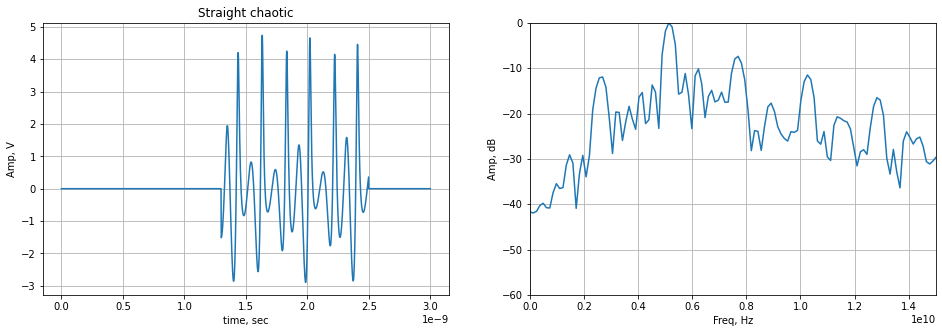

In [23]:
# Построение графика прямохаотического импульса
fig3 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, straight * x)
plt.grid(True)
plt.xlabel("time, sec")
plt.ylabel("Amp, V")
plt.title("Straight chaotic")
plt.subplot(1, 2, 2)
plt.plot(freq, 20 * np.log10(spectr_Chaos_straight / max(spectr_Chaos_straight)))
plt.grid(True)
plt.xlim(0, 1.5 * 10 ** (10))
plt.ylim(-60, 0)
plt.xlabel("Freq, Hz")
plt.ylabel("Amp, dB")

Text(0, 0.5, 'Amp, dB')

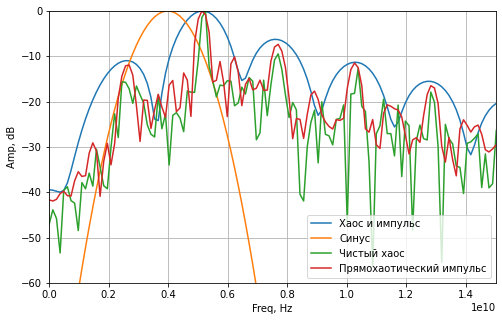

In [24]:
# График спектров UWB-сигнала и спектров с хаосом
fig4 = plt.figure(figsize=(8, 5))
plt.plot(freq, 20 * np.log10(spectr_Chaos / max(spectr_Chaos)), label="Хаос и импульс")
plt.plot(freq, spectr_UWB, label="Синус")
plt.plot(
    freq,
    20 * np.log10(spectr_Chaos_clean / max(spectr_Chaos_clean)),
    label="Чистый хаос",
)
plt.plot(
    freq,
    20 * np.log10(spectr_Chaos_straight / max(spectr_Chaos_straight)),
    label="Прямохаотический импульс",
)
plt.grid(True)
plt.legend()
plt.xlim(0, 1.5 * 10 ** (10))
plt.ylim(-60, 0)
plt.xlabel("Freq, Hz")
plt.ylabel("Amp, dB")

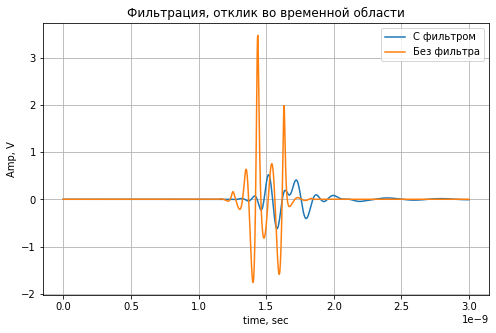

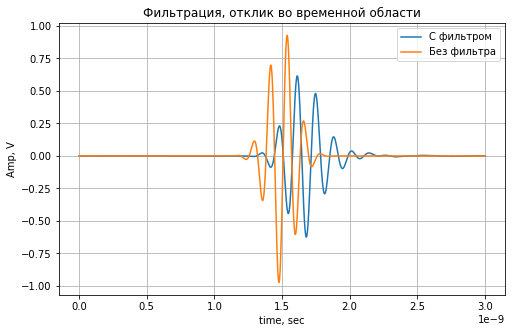

In [25]:
# Пропустим через полосовой фильтр
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtedChaos = butter_bandpass_filter(
    x * Gaussian_pulse, lowcut, highcut, sampling_rate, order=5
)  # Фильтруем хаос
filtedUWB = butter_bandpass_filter(UWB_tip, lowcut, highcut, sampling_rate, order=5)

# Отклик хаоса во временной области
fig7 = plt.figure(figsize=(8, 5))
plt.plot(time, filtedChaos, label="С фильтром")
plt.plot(time, x * Gaussian_pulse, label="Без фильтра")
plt.grid(True)
plt.xlabel("time, sec")
plt.ylabel("Amp, V")
plt.title("Фильтрация, отклик во временной области")
plt.legend()

# Отклик UWB во временной области
fig8 = plt.figure(figsize=(8, 5))
plt.plot(time, filtedUWB, label="С фильтром")
plt.plot(time, UWB_tip, label="Без фильтра")
plt.grid(True)
plt.xlabel("time, sec")
plt.ylabel("Amp, V")
plt.title("Фильтрация, отклик во временной области")
plt.legend()

Text(0.5, 1.0, 'Спектры фильтрованых сигналов')

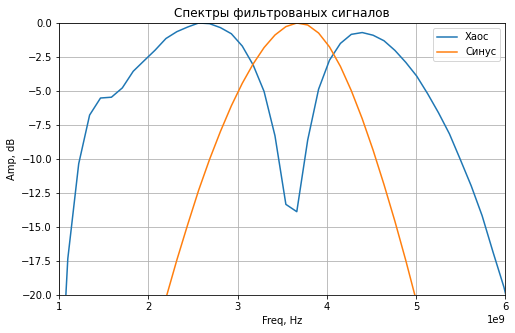

In [26]:
# Спектры хаоса и синуса после фильтра
spectr_Chaos_filt = abs((fft(filtedChaos, N)))
spectr_UWB_filt = abs((fft(filtedUWB, N)))

fig9 = plt.figure(figsize=(8, 5))
plt.plot(freq, 20 * np.log10(spectr_Chaos_filt / max(spectr_Chaos_filt)), label="Хаос")
plt.plot(freq, 20 * np.log10(spectr_UWB_filt / max(spectr_UWB_filt)), label="Синус")
plt.grid(True)
plt.legend()
plt.xlim(1 * 10**9, 6 * 10 ** (9))
plt.ylim(-20, 0)
plt.xlabel("Freq, Hz")
plt.ylabel("Amp, dB")
plt.title("Спектры фильтрованых сигналов")

Text(0.5, 1.0, 'Сигнал после прохождения канала с белым Гауссвоским шумом')

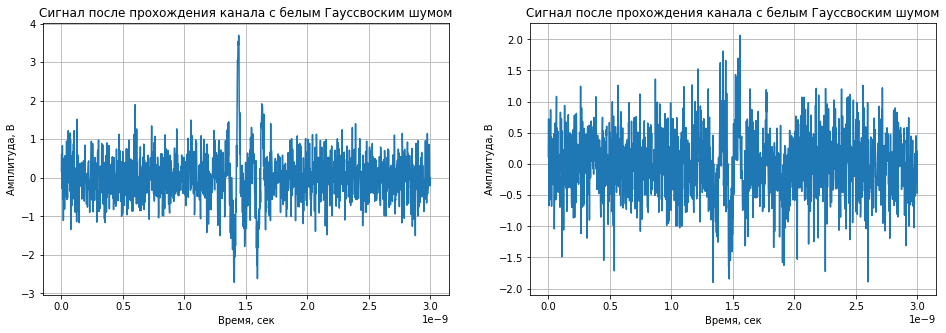

In [27]:
# Моделирование канала связи, простейший случай (без дисперсии, нелинейностей и т.д.). Добавим белый гауссовский шум мощностью 10дБ
def wgn(signal, snr):
    snr = 10 ** (snr / 10.0)
    xpower = np.sum(x**2) / len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower)

Noise = wgn(x * Gaussian_pulse, SNR)

Noise_UWB = wgn(sin * Gaussian_pulse, SNR)

fig10 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, Noise + x * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Время, сек")
plt.ylabel("Амплитуда, В")
plt.title("Сигнал после прохождения канала с белым Гауссвоским шумом")
plt.subplot(1, 2, 2)
plt.plot(time, Noise_UWB + sin * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Время, сек")
plt.ylabel("Амплитуда, В")
plt.title("Сигнал после прохождения канала с белым Гауссвоским шумом")

Text(0.5, 1.0, 'Фильтруем сигнал после канала')

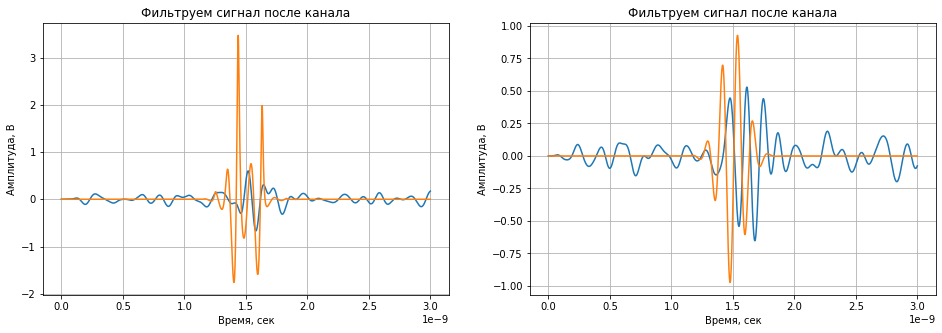

In [28]:
Filt_Noise = butter_bandpass_filter(
    Noise + x * Gaussian_pulse, lowcut, highcut, sampling_rate, order=5
)
Filt_Noise_UWB = butter_bandpass_filter(
    Noise_UWB + sin * Gaussian_pulse, lowcut, highcut, sampling_rate, order=5
)

fig11 = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, Filt_Noise)
plt.plot(time, x * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Время, сек")
plt.ylabel("Амплитуда, В")
plt.title("Фильтруем сигнал после канала")
plt.subplot(1, 2, 2)
plt.plot(time, Filt_Noise_UWB)
plt.plot(time, sin * Gaussian_pulse)
plt.grid(True)
plt.xlabel("Время, сек")
plt.ylabel("Амплитуда, В")
plt.title("Фильтруем сигнал после канала")